In [1]:
import numpy as np
import sympy as sym
import scipy as sp 
from scipy import integrate
import matplotlib.pylab as plt
%matplotlib inline
sym.init_printing()

Base input data

In [2]:
g0 = 9.81 #Gravitational acceleration [m/s^2]
rho = 7874 #Density of sphere [kg/m^3]
diam = 0.1 #Diameter of sphere [m]
height = 1000 #Height of tower [m]
samples = 500 #Number of points (resolution) [/]
duration = 50 #Duration of calculation [s]
y_points,y_step = np.linspace(0,duration,samples, retstep=True) #Points for sampling @TODO: does this need a +1 on number of samples?

# Poročilo samostojnega projekta za pypinm

V tem končnem projektu bomo izvedli simulacijo telesa v prostem padu. S simbolnim računanjem bomo določili vse potrebne vstopne podatke, nato pa numerično določili obnašanje telesa v padcu.

Dodan je še spletni vmesnik, kateri je predstavljen na koncu poročila.

 - simbolno reševanje,
    - Prikaz izračuna v Jupyter Notebook
    - Določanje začetnih konstant
 - sistemi linearnih enačb,
     - ?
 - interpolacija ali aproksimacija,
     - določanje enačbe krivulje pospeška
 - iskanje ničel,
     - določanje terminalne hitrosti?
 - integriranje ali odvajanje,
     - določanje hitrosti in translacije iz interpolirane enačbe pospeška
 - reševanje diferencialnih enačb.
     - reševanje enačbe padca skozi zrak


## Nosilna enačba
Naša glavna enačba, iz katere bomo izhajali, je diferencialna enačba prostega pada.

$$m\ddot{y}+(\frac{1}{2}CA\rho)\dot{y}-mg=0$$

## Simbolni izračun

Želimo izračunati vstopne podatke in konstante za izračun diferencialne enačbe. Potrebujemo določiti:
    - Maso padajoče kroglje
    - Gostota plina skozi katerega pada kroglja
    - Konstanto zračnega upora 
$$k=\frac{1}{2}CA\rho$$

### Masa

Maso telesa v prostem padu bomo izračunali s pomočjo enostavne odvisnoti med gostoto in volumnom.

$$m = \rho*V$$
$$V = \frac{4}{3} *\pi*r^3$$
$$m = \frac{4}{3}*\rho*\pi*r^3 $$

In [3]:
from sympy import Rational
from sympy.solvers import solve

Nastavimo enačbo za izračun mase
- (Opomba: ta korak je tukaj nepotreben, pravzaprav je izračun mase s simbolnim računanjem nepotreben in brez razloga zakompliciran. V simulaciji je ubrana bolj smiselna bližnica z uporabo navadne funkcije.)

In [4]:
_m, _rho, _r = sym.symbols('m, rho, r')
eq = sym.Eq(_m, Rational(4,3)*_rho*sym.pi*_r**3)
eq

Vstavimo naše vstopne podatke in izračunamo maso.

In [5]:
m = solve(eq.subs({_rho:rho,_r:diam/2}),_m)
m

Določimo float število za nadaljne izračune

In [6]:
m = m[0].evalf()
print(f'Masa je {round(m,2)} kg')

Masa je 4.12 kg


## Izračun tlaka
Preden lahko izračunamo konstanto sile upora potrebujemo izračunati gostoto zraka. To lahko izračunamo iz plinske enačbe:
$$ p*V = \frac{m*R_u*T}{M} $$
in enakosti 
$$m = \rho*V$$

In [7]:
_p, _V, _rho, _R_u, _T, _M = sym.symbols('p, V, rho, R_u, T, M')
eq = sym.Eq(_p*_V,_rho*_V*_R_u*_T/_M)
eq

Iz enačbe izpostavimo gostoto

In [8]:
rho_air = solve(eq,_rho)
rho_air

Sedaj potrebujemo še konstante.

In [9]:
from scipy import constants

In [10]:
rho_air_value = rho_air[0].subs({
    _R_u:constants.R, #Plinska konstanta [ J mol^-1 K^-1]
    _M: 28.96/1000, # Molska masa zraka [kg/mol] - https://socratic.org/questions/what-is-the-molecular-weight-of-air
    _T: 20+273.15, #Temperatura okolice [K]
    _p: 1*10**5 #Tlak okolice [Pa]
}).evalf()
print(f'Gostota zraka je: {round(rho_air_value,2)} kg/m3') ##Gostota zraka [kg/m^3]

Gostota zraka je: 1.19 kg/m3


## Koeficient trenja
Potrebujemo izračunati še konstanto upora v naši enačbi hitrosti padanja. Izračunamo jo iz sledeče enačbe:

$$ F_u = -\frac{1}{2}*C*\rho*A*v^2 $$
Kjer je naša konstanta:
$$ k = \frac{1}{2}*C*\rho*A $$

C je praviloma določen izkustveno. Za sferične predmete je C v visko turbolentnem toku približno enak 0.1
(https://www.grc.nasa.gov/www/k-12/airplane/dragsphere.html)

In [11]:
_k, _C, _A, _v = sym.symbols('k, C, A v')
_k = 1/2*_C*_rho*_A*_v**2
_k

Preliminarno določimo k.

In [12]:
k = _k.subs({
    _C: 0.5,
    _A: sym.pi*(diam)**2/4,
    _rho: rho_air_value/1000,
    _v:100
}).evalf()
k

# Izračun hitrosti padanja
Enačbo $$m\ddot{y}+(\frac{1}{2}CA\rho)\dot{y}-mg=0$$ bomo sedaj rešili s uporabo eulerjeve metode. Naš rezultat bo hitrost v smeri y.


$$ k = \frac{1}{2}*C*\rho*A $$

In [13]:
from scipy.integrate import solve_ivp

In [14]:
def fun(x, y, g=9.81, m=30, d=0.1, rho=1.18/1000, mu=0.0000157):
    # Konstante izračuna Cd ( https://www.researchgate.net/publication/244155878 )
    A=0.1806
    B=0.6459
    C=0.4251
    D=6880.95
    
    # Izračun Cd vključuje deljenje z hitrostjo. Ker je pri začetnem pogoju le-ta enaka 0 ji prištejemo nekaj zelo majhnega.   
    Re = d*y[1]*rho/mu+0.000000001
    Cd = 24/Re*(1+A*Re**B)+C/(1+D/Re)
    
    #Izračun konstante
    k = (((d/2)**2)*Cd*rho*y[1]**2)/2
    #Vrnjen vektor
    return np.array([y[1], g-k/m*y[1]**2])

In [15]:
#Pogoj kdaj se izračun diferencialne enačbe konča
tla = lambda x,y: height-y[0]
tla.terminal = True
tla.direction = -1

#Numerični izračun rešitve
res = solve_ivp(lambda t, y: fun(t, y, m=m, d=diam, rho=float(rho_air_value/1000)), [y_points[0], y_points[-1]], y0=np.array([0,0]), t_eval=y_points,events=tla)
y,v=res.y

#Izračun pospeška
a=fun(y_points,res.y,m=m, d=diam, rho=float(rho_air_value/1000))[1]

In [16]:
#Trajanje padca iz višine {height}
print(f'Trajanje padca: {round(res.t[-1],2)}s')

#Število vzorcev
print(f'Število vzorcev: {len(res.t)}, korak dt: {round(res.t[-1]/len(res.t),3)}s')

Trajanje padca: 16.63s
Število vzorcev: 167, korak dt: 0.1s


### Izris rezultatov izračuna
V naslednjih tabelah lahko vidimo izrisane profile predmeta v padcu. Odziv ustreza pričakovanemu, s hitrostjo se manjša pospešek, saj v diferencialni enačbi s hitrostjo narašča vpliv člena `k`. Na neki točki je le-ta dovolj velik da ustavi pospeševanje. Tu je dosežena terminalna hitrost.

Text(0.5, 1.0, 'Translation')

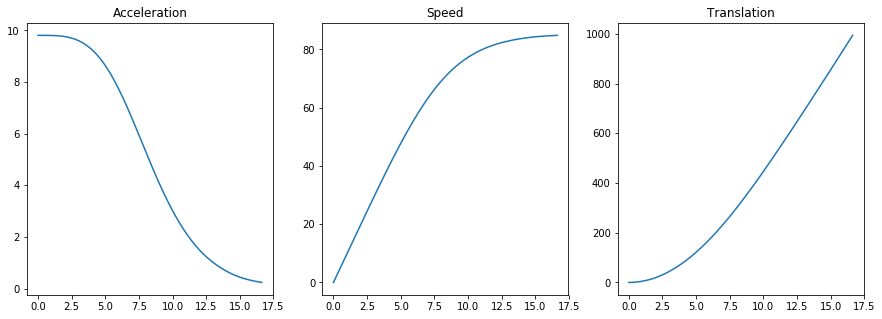

In [17]:
fig, axs  = plt.subplots(1, 3,figsize=(15,5))
axs[0].plot(res.t, a)
axs[0].set_title('Acceleration')
axs[1].plot(res.t, v)
axs[1].set_title('Speed')
axs[2].plot(res.t, y)
axs[2].set_title('Translation')

## Interpolacija in določitev terminalne hitrosti

Sedaj bomo s pomočjo interpolacije točk pospeševanja določili kdaj funkcija začne limitirati proti 0. Takrat vemo, da smo dosegli terminalno hitrost.

Najprej določimo naše zlepke polinomov

In [18]:
from scipy.interpolate import InterpolatedUnivariateSpline

In [19]:
spl = InterpolatedUnivariateSpline(res.t, a, k=3)

Text(0.5, 1.0, 'Interpolated Translation')

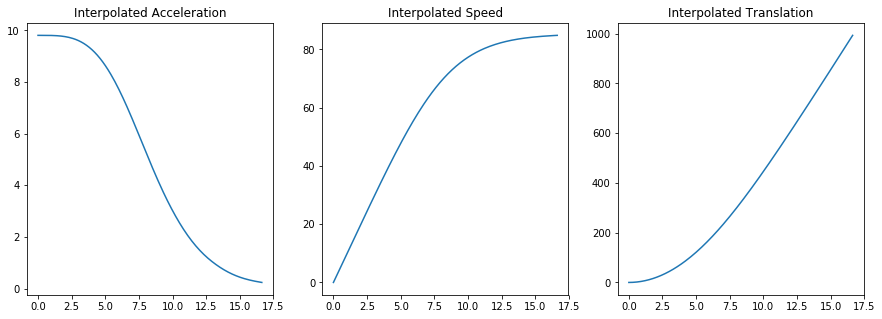

In [20]:
fig, axs  = plt.subplots(1, 3,figsize=(15,5))
axs[0].plot(res.t, spl(res.t))
axs[0].set_title('Interpolated Acceleration')
axs[1].plot(res.t, spl.antiderivative(1)(res.t))
axs[1].set_title('Interpolated Speed')
axs[2].plot(res.t, spl.antiderivative(2)(res.t))
axs[2].set_title('Interpolated Translation')

Sedaj lahko s pomočjo integracije določimo še prepotovano pot.

In [21]:
print(f'Prepotovana pot padca je: {round(spl.antiderivative(1).integral(0,res.t[-1]),2)}m')

Prepotovana pot padca je: 993.36m


## Iskanje ničel funkcije

Kot je na grafu razvidno, lahko opazimo, da začne funkcija pospeška nihati okoli ničle. To lahko izkoristimo, da najdemo prvo ničlo ter tam določimo terminalno hitrost.

In [22]:
from scipy.optimize import newton

In [23]:
print(f'Prva ničla se nahaja pri: {round(newton(spl, 5, maxiter=50),2)}s')
print(f'Terminalna hitrost je: {round(float(spl.antiderivative(1)(21)), 2)} m/s')

Prva ničla se nahaja pri: 18.68s
Terminalna hitrost je: 84.27 m/s


# Aplikacija in strežnik 

Poročilu je dodan še strežnik in spletni klijent za uporabo strežnika. Le-tega je potrebno pognati s pomočjo zunanje orodne vrstice (CMD, Anaconda Prompt, Powershell....), saj jupyter ne podpira izvajanja strežniške kode.

Prav take je so pravilno delovanje potrebna PIP paketa python-socketio in aiohttp, ter spremljajoče odvisnosti. 
Te lahko naložite z uporabo ukaza `$ pip install -r requirements.txt` iz root mape tega projekta. T.j. lokacija tega jupyter notebooka.

Nato se program požene s pomočjo ukaza `$ python app.py`. V spletnem brskalniku se lahko na strežnik povežete preko naslova `http://localhost:8080`



V primeru, da ne želite nalagati vseh PIP paketov, oz. iz kakšnega razloga aplikacija ne deluje so v mapi `/slike` priložene slike, ki prikažejo delovanje aplikacije.